# Lab 3: Clasificacion con Secuencias de Proteinas (usando PLMs)

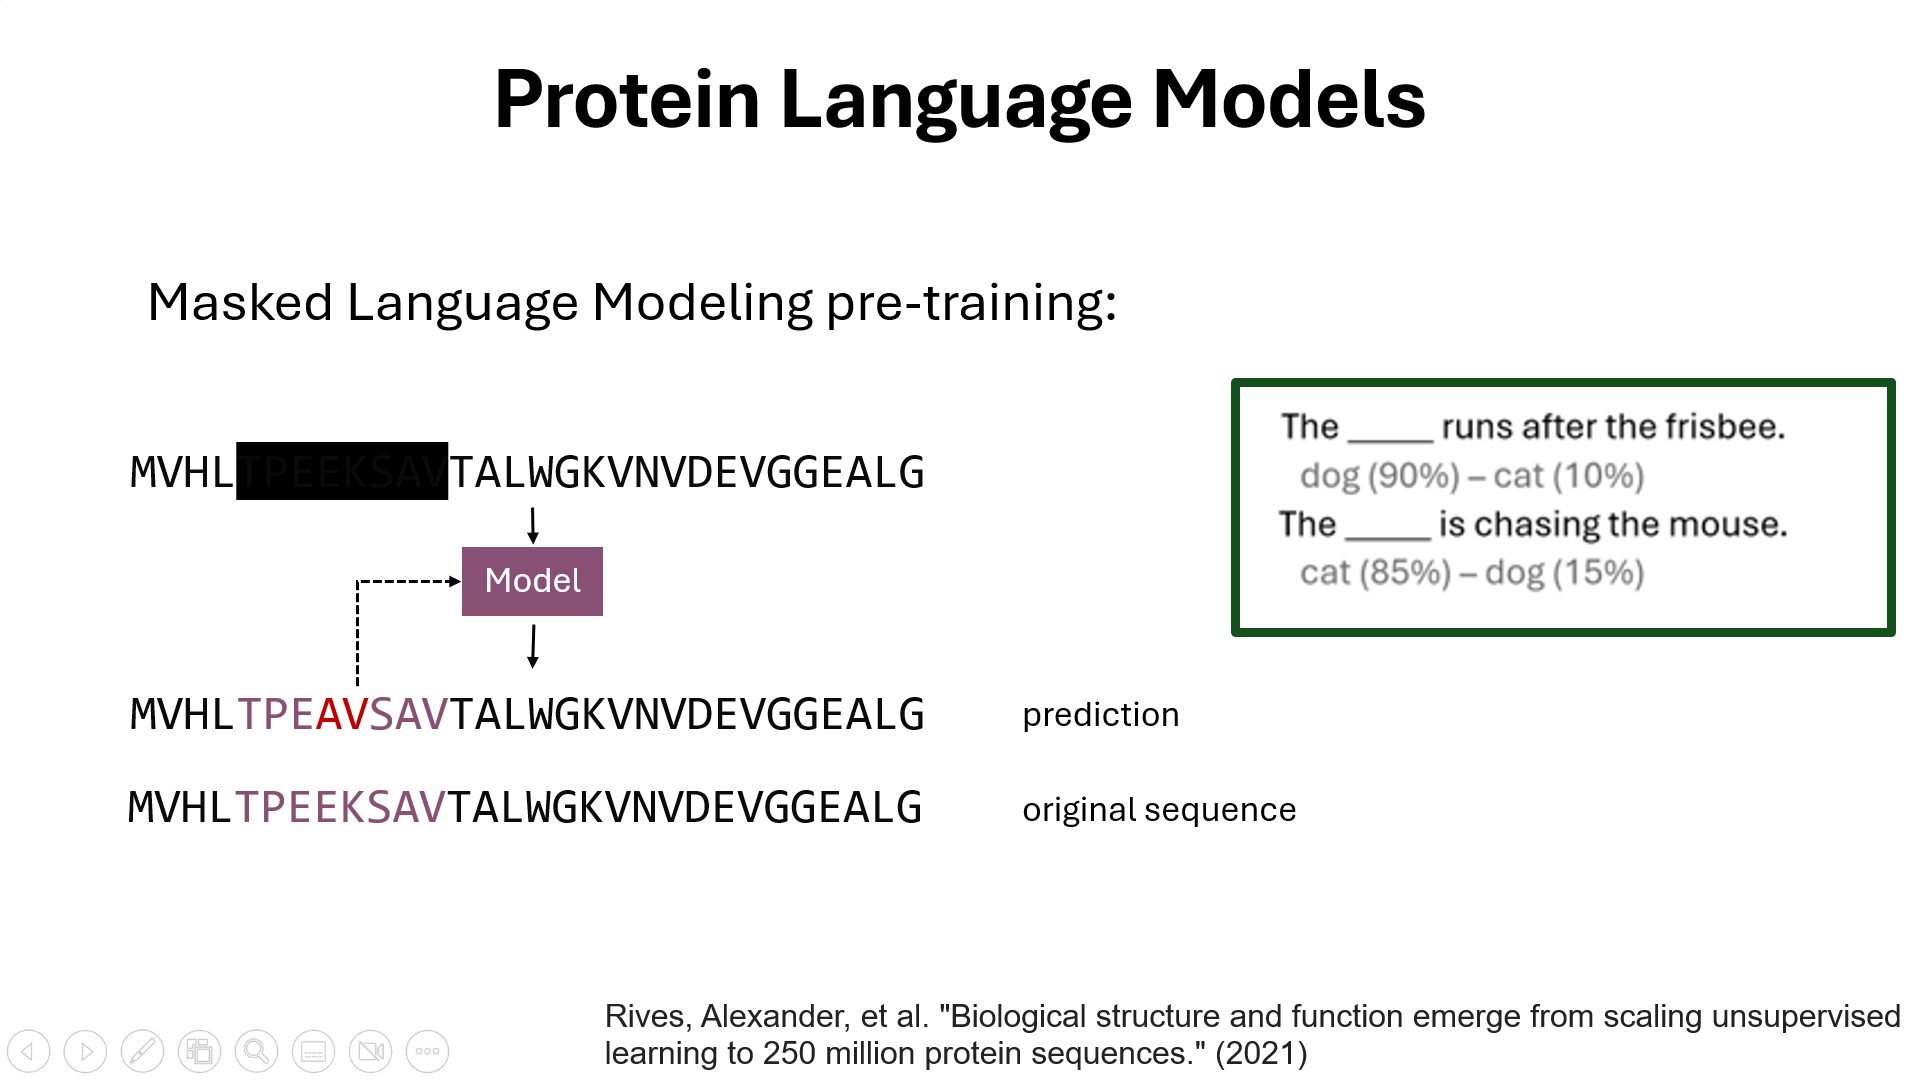

In [ ]:
# Importar las librerias
import os
import numpy as np
import pandas as pd

# Importar funciones para clasificacion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Importar Modelos para clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Importar la libreria de Modelos de Lenguaje
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# Importar barras
from tqdm.auto import tqdm


In [ ]:
# Importar el PLM
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

# Check if GPU is available and move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=320, out_feat

In [ ]:
sequence = "SLFEQLGGQAAVQAVTAQFYANIQADATVATFFNGIDMPNQTNKT"

tokenized_sequence = tokenizer(sequence, return_tensors="pt")
print(tokenized_sequence)

output = model(tokenized_sequence['input_ids'], output_hidden_states=True)
output

{'input_ids': tensor([[ 0,  8,  4, 18,  9, 16,  4,  6,  6, 16,  5,  5,  7, 16,  5,  7, 11,  5,
         16, 18, 19,  5, 17, 12, 16,  5, 13,  5, 11,  7,  5, 11, 18, 18, 17,  6,
         12, 13, 20, 14, 17, 16, 11, 17, 15, 11,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


MaskedLMOutput(loss=None, logits=tensor([[[ 14.7313,  -8.6258,  -5.6999,  ..., -15.5973, -15.7520,  -8.6282],
         [ -7.6657, -17.2249,  -8.2786,  ..., -16.0528, -16.3453, -17.2307],
         [ -9.8725, -19.0032, -10.9593,  ..., -16.0355, -16.0468, -18.9944],
         ...,
         [-10.5681, -18.1379, -10.7089,  ..., -16.2514, -16.1705, -18.1345],
         [ -9.3799, -18.1463,  -9.9816,  ..., -16.1111, -16.0550, -18.1448],
         [ -6.5862,  -8.8181,  15.5989,  ..., -16.5235, -16.4004,  -8.8662]]],
       grad_fn=<AddBackward0>), hidden_states=(tensor([[[-0.1720, -0.2421, -0.1315,  ...,  0.1121, -0.0918, -0.0569],
         [-0.0763, -0.0188,  0.0164,  ..., -0.0555,  0.0229,  0.0293],
         [-0.0754, -0.0198,  0.0375,  ...,  0.0728,  0.0788,  0.0787],
         ...,
         [-0.0859,  0.0139,  0.0296,  ...,  0.0030,  0.0197,  0.0253],
         [-0.0635, -0.0588,  0.0576,  ...,  0.0056,  0.0807, -0.0806],
         [ 0.0643, -0.2711, -0.1030,  ..., -0.1941, -0.3021, -0.0014]]],


In [ ]:
# Cargar datos previos
sequence_df = pd.read_csv("scop_alpha_vs_beta.csv", index_col=0)
sequence_df[0:3]

,sequence,label
0,MKQLTILGSTGSIGCSTLDVVRHNPEHFRVVALVAGKNVTRMVEQC...,a
1,DKSERQAALASAPHDTVDVVVVGSGGAGFSAAISATDSGAKVILIE...,a
2,ADNLAEFHVQNQECDSCHTPDGELSNDSLTYENTQCVSCHGTLEEV...,a


In [ ]:
original_df = sequence_df
sequence_df = sequence_df.sample(frac=0.5)

In [ ]:
def get_protein_embeddings(sequences):
    embeddings = []
    for seq in tqdm(sequences, desc="Generating embeddings"):
        tokenized_sequence = tokenizer(seq, return_tensors="pt",
                                       add_special_tokens=False).to(device)

        # Ensure no_grad to prevent memory issues and speed up inference
        with torch.no_grad():
            output = model(tokenized_sequence['input_ids'],
                           output_hidden_states=True)
        # The last hidden state is usually the last element in output.hidden_states
        hidden_state = output.hidden_states[-1]
        # Perform pooling by taking the mean of the hidden states across the sequence length
        # Exclude the CLS and EOS tokens if add_special_tokens=True was used, but here we set it to False
        # So we just take the mean of all token embeddings for the sequence
        pooled_embedding = hidden_state.mean(dim=1)
        embeddings.append(pooled_embedding.squeeze().cpu().numpy())
    stacked_embeddings = np.stack(embeddings)
    return stacked_embeddings

In [ ]:
embeddings = get_protein_embeddings(sequence_df["sequence"].tolist())

Generating embeddings:   0%|          | 0/9094 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
X = embeddings
y = sequence_df['numerical_label'].values

print(f"Dimension de (X): {X.shape}")
print(f"Dimension de (y): {y.shape}")

NameError: name 'embeddings' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4562, 320)
Shape of X_test: (1141, 320)
Shape of y_train: (4562,)
Shape of y_test: (1141,)


In [ ]:
model = LogisticRegression(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       541
           1       0.99      0.99      0.99       600

    accuracy                           0.99      1141
   macro avg       0.99      0.99      0.99      1141
weighted avg       0.99      0.99      0.99      1141

